In [1]:
import feather
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [9]:
#read in gene expression matrix
all_cells_path = 'all_cells.feather'
all_cells_df =  feather.read_dataframe(all_cells_path)

In [8]:
#read in annoations
annot_path = "all_cells_annotation.csv"
annot_df = pd.read_csv(annot_path,index_col=0)

In [10]:
annot_df = annot_df.drop('Unnamed: 0.1',1)

In [20]:
annot_df

cell_id  nUMIs  nGenes  doublet_score     region  \
0      AAACCCAAGCGCGTTC-1  17127    5142       1.695648  m1newhand   
1      AAACCCAAGGGCGAGA-1   6498    2677       0.191302  m1newhand   
2      AAACCCACAACCGATT-1   8665    3165       0.162830  m1newhand   
3      AAACCCACAAGCGCTC-1   5508    2507       0.135110  m1newhand   
4      AAACCCACACGAAAGC-1  18966    5107       0.128000  m1newhand   
...                   ...    ...     ...            ...        ...   
17355  TTTGTTGTCATTTCCA-1   9319    3342       0.532369  m1newhand   
17356  TTTGTTGTCCTAACAG-1   3892    1894       0.131001  m1newhand   
17357  TTTGTTGTCGGTAGAG-1  18445    5415       0.776190  m1newhand   
17358  TTTGTTGTCTGGGATT-1  12916    4242       0.299232  m1newhand   
17359  TTTGTTGTCTTCCAGC-1  11941    3874       0.130162  m1newhand   

                            full_id  
0      m1newhand_AAACCCAAGCGCGTTC-1  
1      m1newhand_AAACCCAAGGGCGAGA-1  
2      m1newhand_AAACCCACAACCGATT-1  
3      m1newhand_AAACCCACAAGCGCTC-1  
4      m1newhand_AAACCCACACGAAAGC-1  
...                             ...  
17355  m1newhand_TTTGTTGTCATTTCCA-1  
17356  m1newhand_TTTGTTGTCCTAACAG-1  
17357  m1newhand_TTTGTTGTCGGTAGAG-1  
17358  m1newhand_TTTGTTGTCTGGGATT-1  
17359  m1newhand_TTTGTTGTCTTCCAGC-1  

[56085 rows x 6 columns]

In [12]:
#remove doublets as annoated by scds previosly
singlets = annot_df["doublet_score"].values<0.7
singlets_df = all_cells_df.loc[singlets,:]
singlets_annot = annot_df.loc[singlets,:]

In [13]:
#create an annotated dataframe object and add annotation columns
striatum_ann = AnnData(singlets_df)
striatum_ann.var_names = all_cells_df.columns.values
striatum_ann.obs_names = singlets_annot["full_id"].values
striatum_ann.obs["nUMIs"] = singlets_annot["nUMIs"].values
striatum_ann.obs["nGenes"] = singlets_annot["nGenes"].values

striatum_ann.obs["region"] = pd.Categorical(singlets_annot["region"].values,np.unique(singlets_annot["region"].values))

striatum_ann.obs["doublet_score"] = singlets_annot["doublet_score"].values

Transforming to str index.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [14]:
#for preclustering we will use CPM normalization
sc.pp.normalize_per_cell(striatum_ann, counts_per_cell_after=1e6)
sc.pp.log1p(striatum_ann)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
#we now run pca on the gene expression matrix and construct a knn graph
sc.pp.pca(striatum_ann)
sc.pp.neighbors(striatum_ann)


/pylon5/mc5plqp/mkleyman/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../mkleyman/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/pylon5/mc5plqp/mkleyman/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../mkleyman/anaconda3/lib/py

In [16]:
#we can now cluster the cells via leiden clustering  #https://doi.org/10.1038/s41598-019-41695-z
sc.tl.leiden(striatum_ann, key_added='groups',resolution=0.1)

In [17]:
#we can visualize our clusters with UMAP projection
sc.tl.umap(striatum_ann)

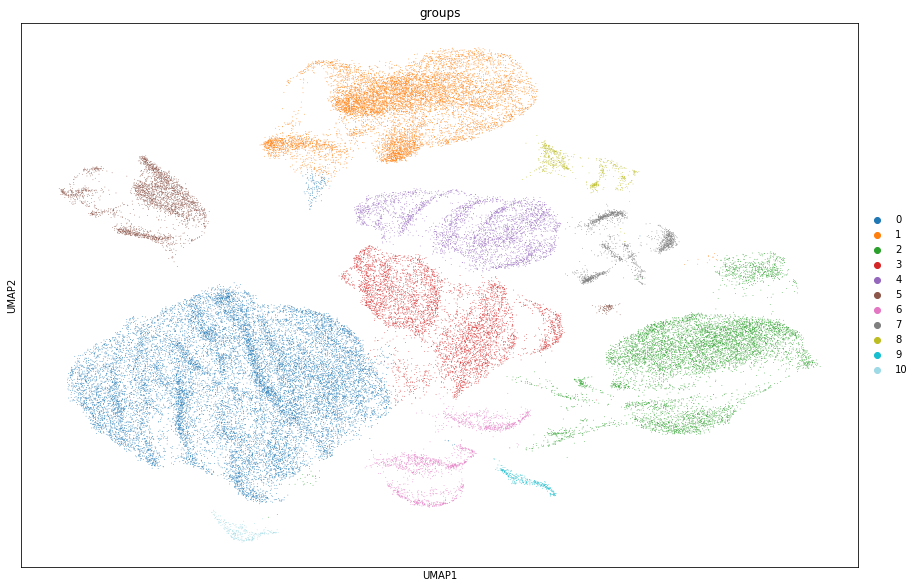

In [18]:
#color by leiden cluster
sc.pl.umap(striatum_ann,color="groups",palette="tab20")

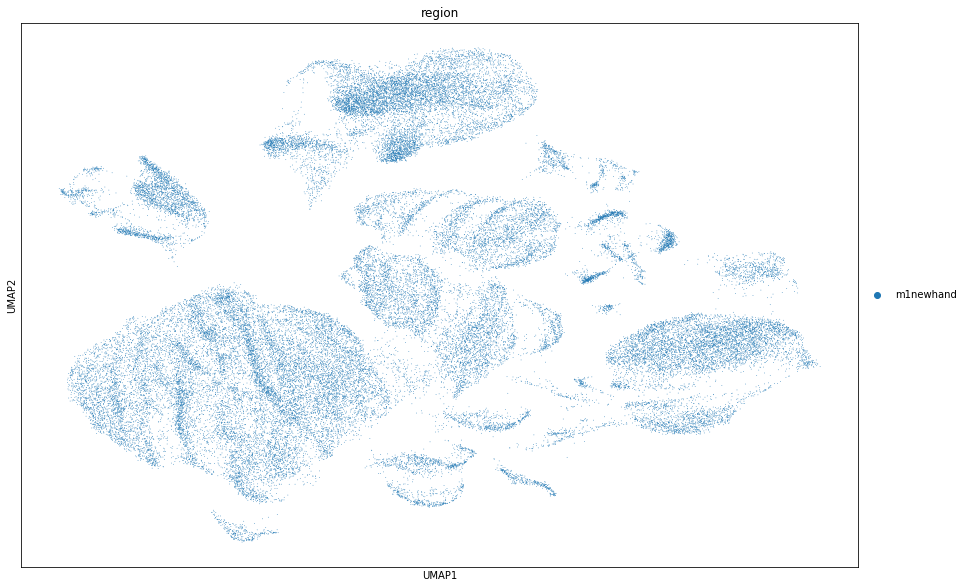

In [19]:
#color by region sampled from
sc.pl.umap(striatum_ann,color="region",palette="tab20")

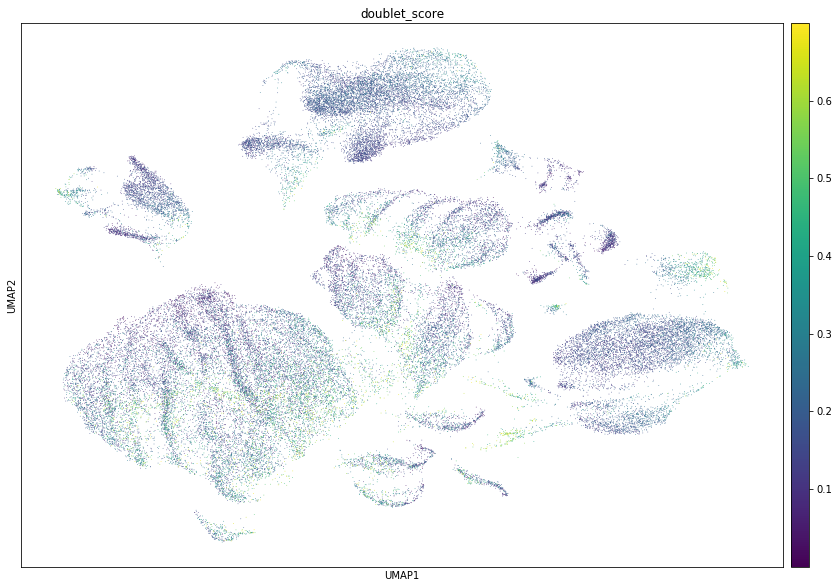

In [21]:
#let's look at doublet statistics for our clusters
sc.pl.umap(striatum_ann,color="doublet_score")

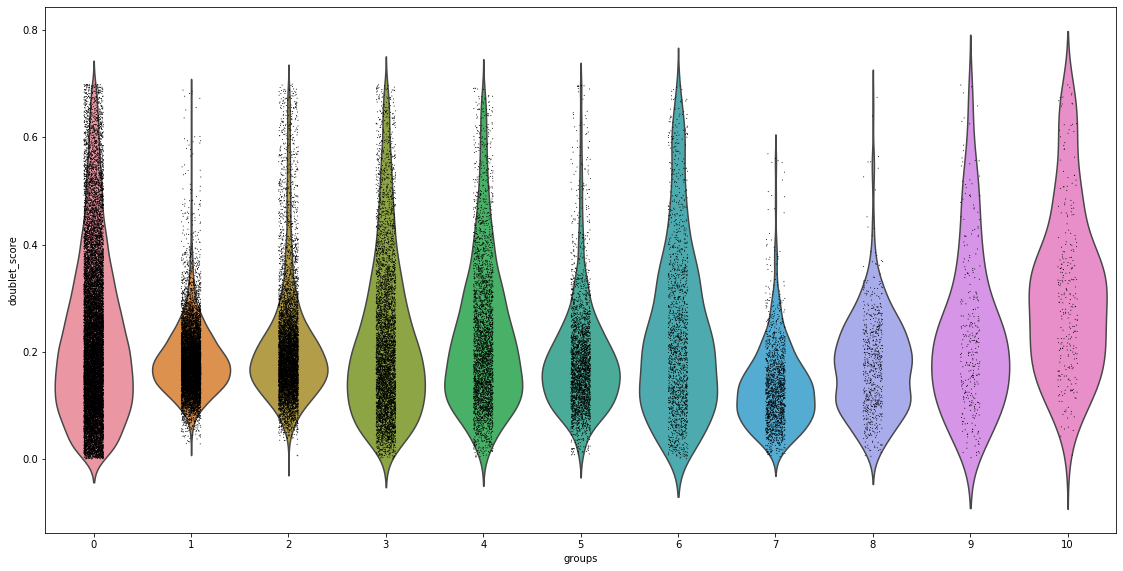

In [22]:
#some clusters seem to have higher doublet scores than others
sc.pl.violin(striatum_ann,keys="doublet_score",groupby="groups")

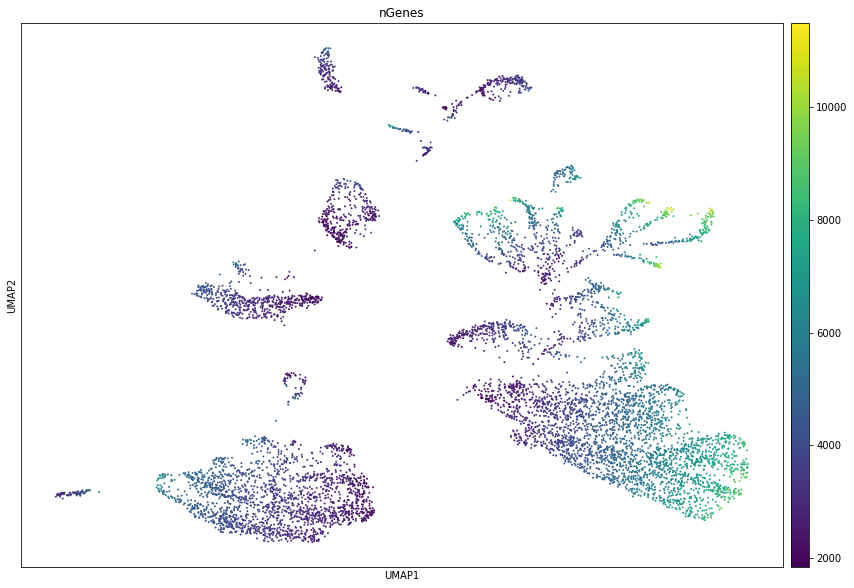

In [17]:
#let's look at number of genes per cell
sc.pl.umap(striatum_ann,color="nGenes")

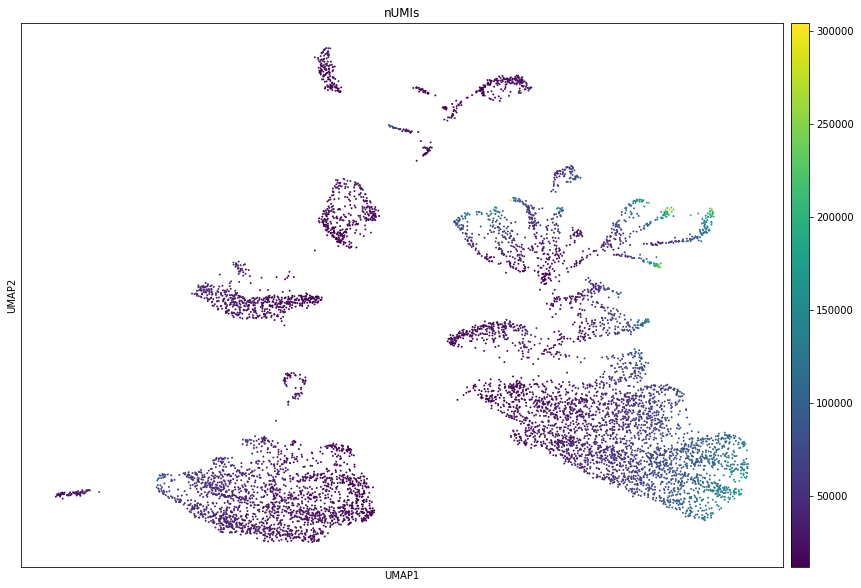

In [18]:
#let's look at number of UMIs per cell

sc.pl.umap(striatum_ann,color="nUMIs")

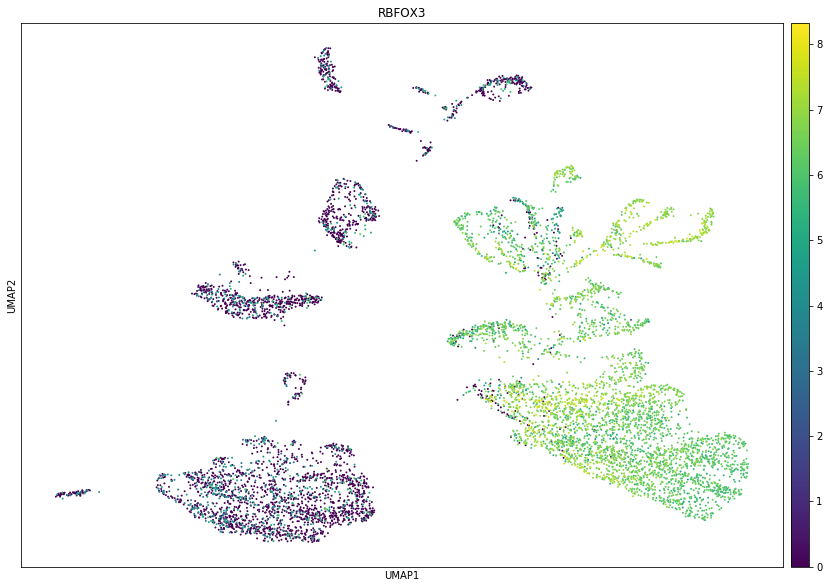

In [19]:
#Marker for all neurons
sc.pl.umap(striatum_ann,color="RBFOX3")

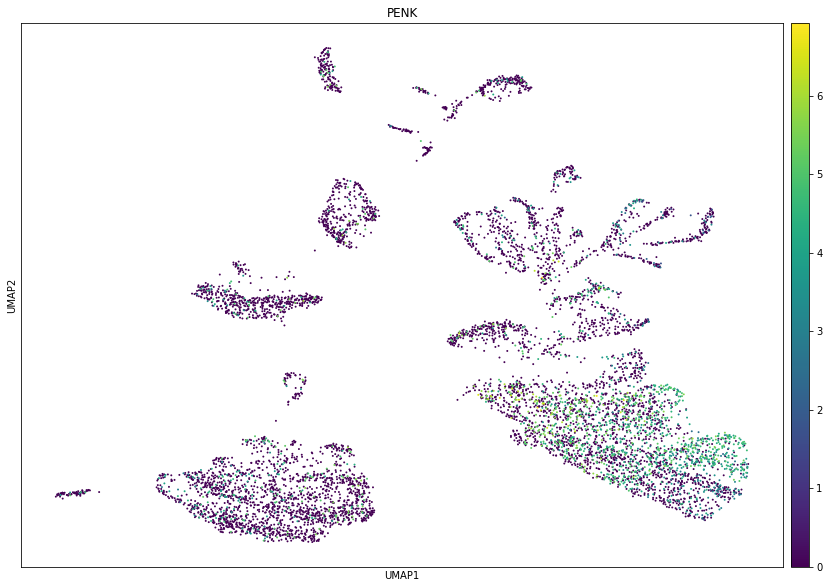

In [20]:
#Marker for D1 neurons
sc.pl.umap(striatum_ann,color="PENK")

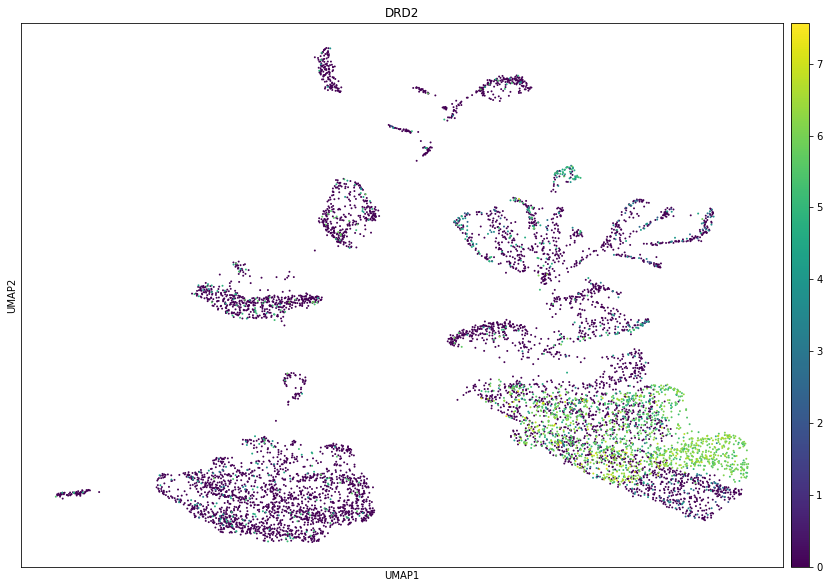

In [21]:
#Marker for D2 neurons

sc.pl.umap(striatum_ann,color="DRD2")

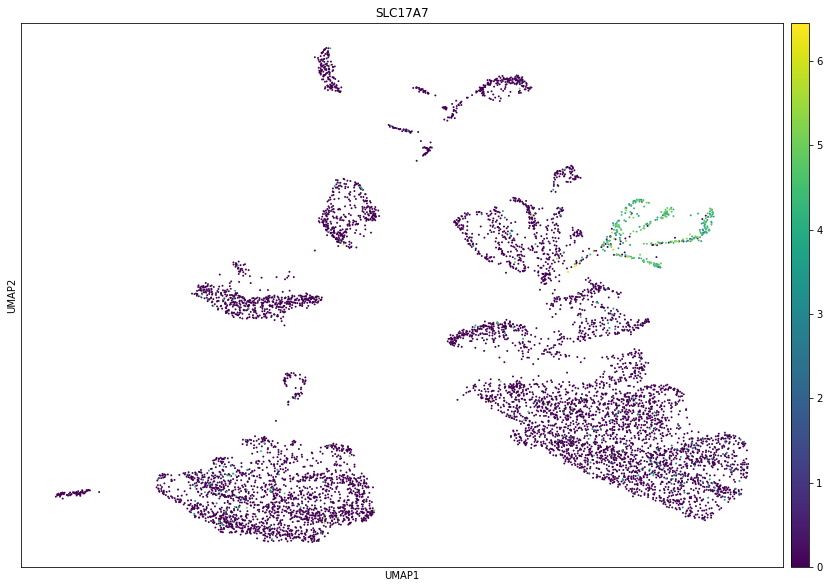

In [22]:
#Marker for excitatory neuron contamination
sc.pl.umap(striatum_ann,color="SLC17A7")

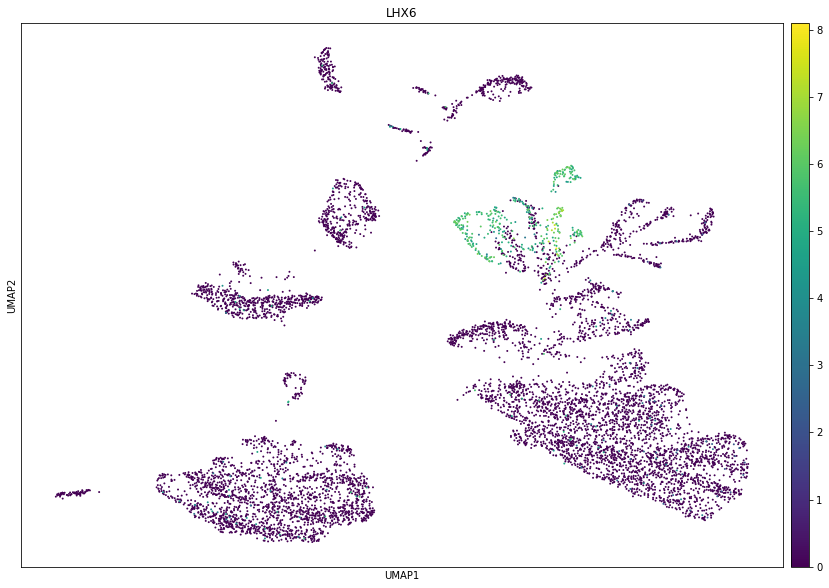

In [23]:
#Marker for inhibotry interneurons
sc.pl.umap(striatum_ann,color="LHX6")

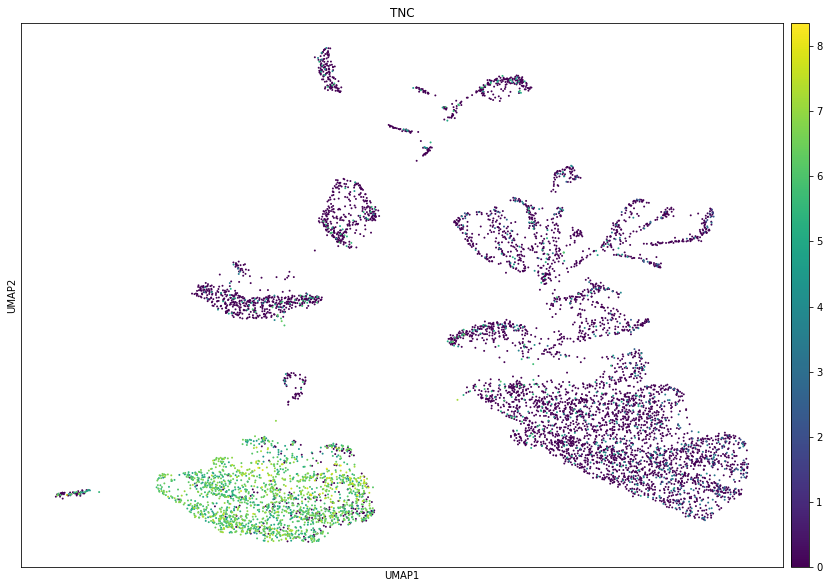

In [24]:
#Marker for astrocytes
sc.pl.umap(striatum_ann,color="TNC")

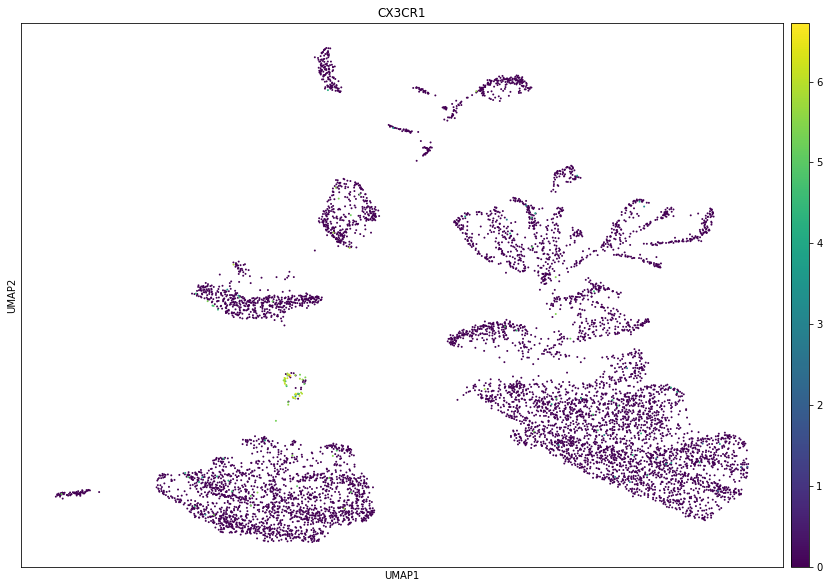

In [25]:
#Marker for microglia
sc.pl.umap(striatum_ann,color="CX3CR1")

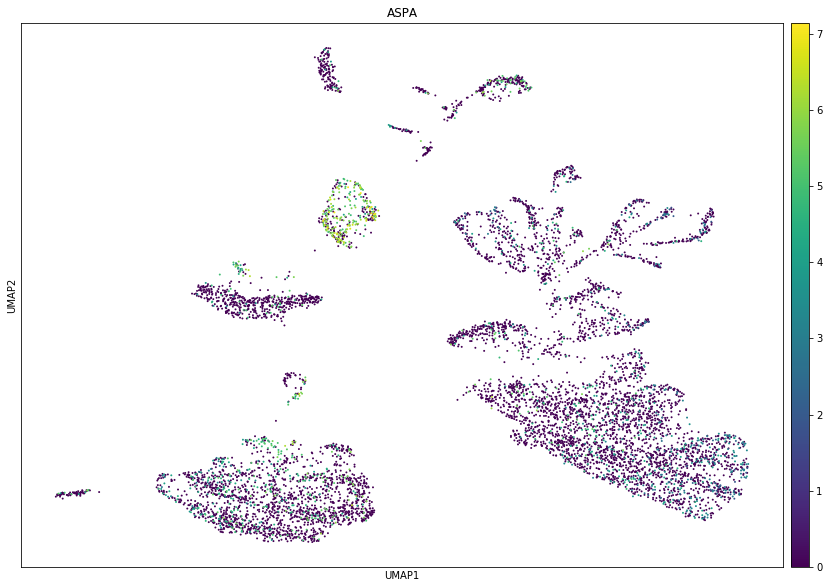

In [26]:
#Marker for oligodendrocytes
sc.pl.umap(striatum_ann,color="ASPA")

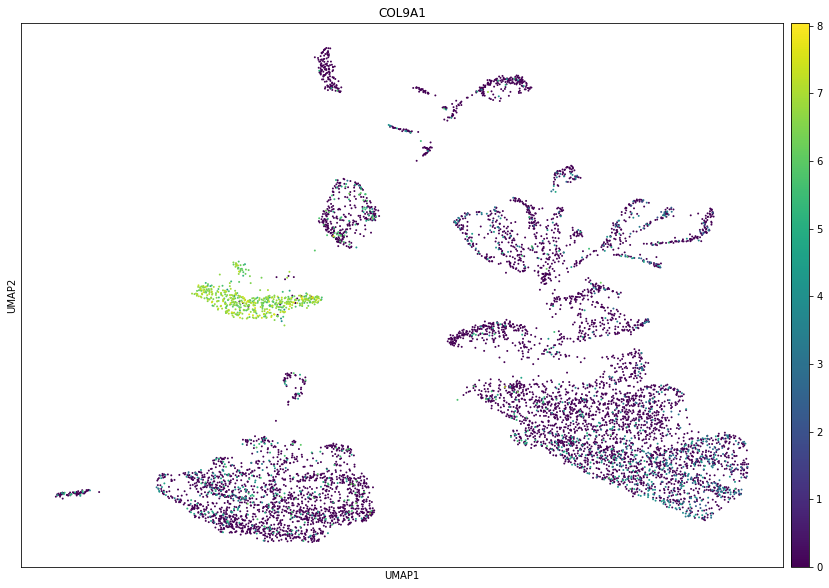

In [27]:
#Marker for oligodendrocyte percursor cells
sc.pl.umap(striatum_ann,color="COL9A1")

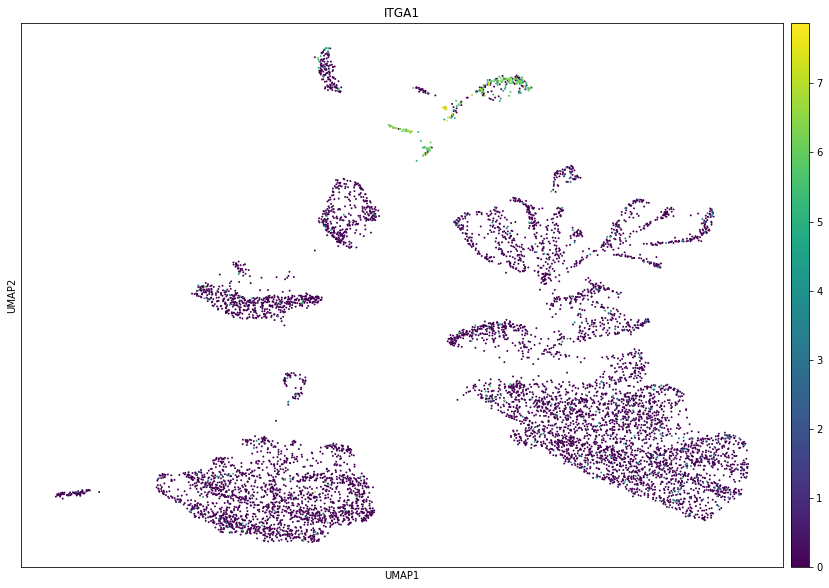

In [28]:
#Marker for endothelial cells
sc.pl.umap(striatum_ann,color="ITGA1")

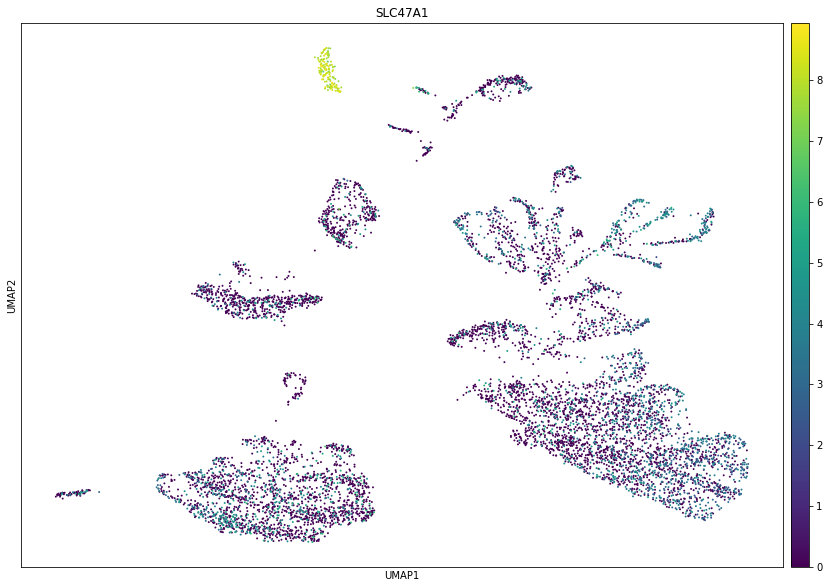

In [29]:
#marker for mural cells
sc.pl.umap(striatum_ann,color="SLC47A1")

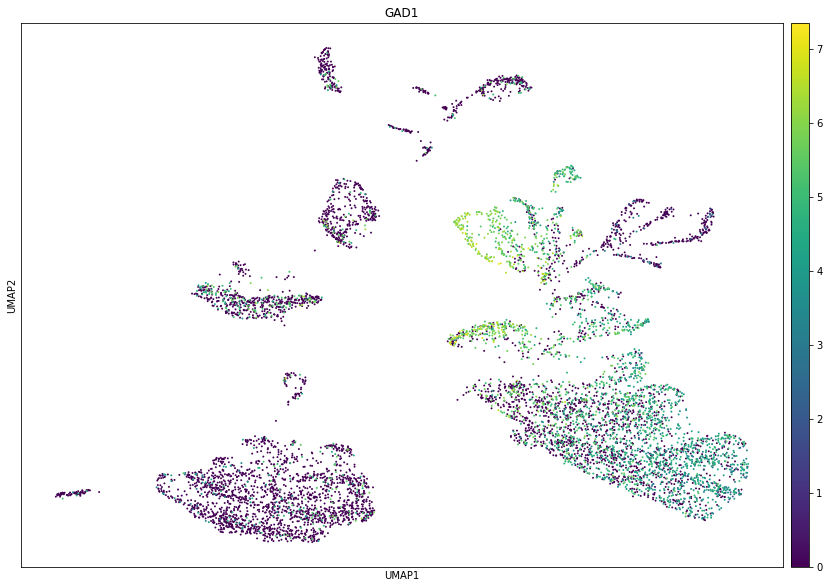

In [30]:
#marker for inhibitory neurons
sc.pl.umap(striatum_ann,color="GAD1")

In [31]:
#we can see some broad clusters here labeled by consitutive markers
#we want to do some further qc
excitatory_neuron_contamination_idx = np.asarray([group=="5" for group in striatum_ann.obs["groups"].values])
inhibitory_neuron_idx = np.asarray([group in ['0','2','7'] for group in striatum_ann.obs["groups"].values])
non_neuron_idx = np.logical_not(np.logical_or(excitatory_neuron_contamination_idx,inhibitory_neuron_idx))

In [32]:
#we are going to do a second step of qc individually for inhibitory neurons and non neurons 
#because neurons on average express signficicantly more transcripts than glia DOI: 10.1126/science.aav8130
inhibitory_neuron_df = singlets_df.loc[inhibitory_neuron_idx,:]
inhibitory_neuron_annot = singlets_annot.loc[inhibitory_neuron_idx,:]
non_neuron_df = singlets_df.loc[non_neuron_idx,:]
non_neuron_annot = singlets_annot.loc[non_neuron_idx,:]

In [33]:
inhibitory_neuron_ann = AnnData(inhibitory_neuron_df)
inhibitory_neuron_ann.obs_names = inhibitory_neuron_annot["full_id"].values
inhibitory_neuron_ann.obs["nUMIs"] = inhibitory_neuron_annot["nUMIs"].values
inhibitory_neuron_ann.obs["nGenes"] = inhibitory_neuron_annot["nGenes"].values

inhibitory_neuron_ann.obs["region"] = pd.Categorical(inhibitory_neuron_annot["region"].values,np.unique(inhibitory_neuron_annot["region"].values))

inhibitory_neuron_ann.obs["doublet_score"] = inhibitory_neuron_annot["doublet_score"].values

Transforming to str index.


In [34]:
sc.pp.normalize_per_cell(inhibitory_neuron_ann, counts_per_cell_after=1e6)
sc.pp.log1p(inhibitory_neuron_ann)
sc.pp.pca(inhibitory_neuron_ann)
sc.pp.neighbors(inhibitory_neuron_ann)
sc.tl.umap(inhibitory_neuron_ann)


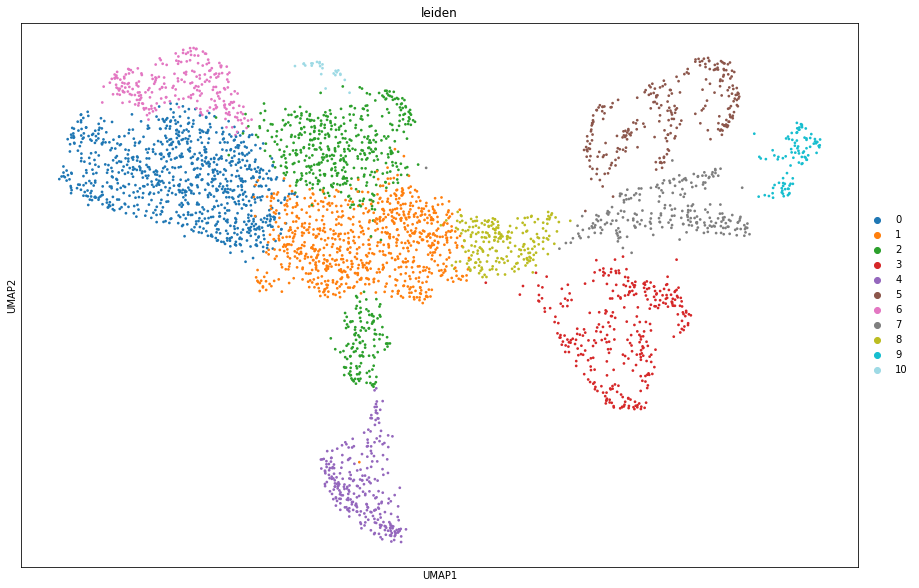

In [35]:
#let's look at a course grained clustering of the neurons
sc.tl.leiden(inhibitory_neuron_ann,resolution=0.5)
sc.pl.umap(inhibitory_neuron_ann,color="leiden",palette="tab20")

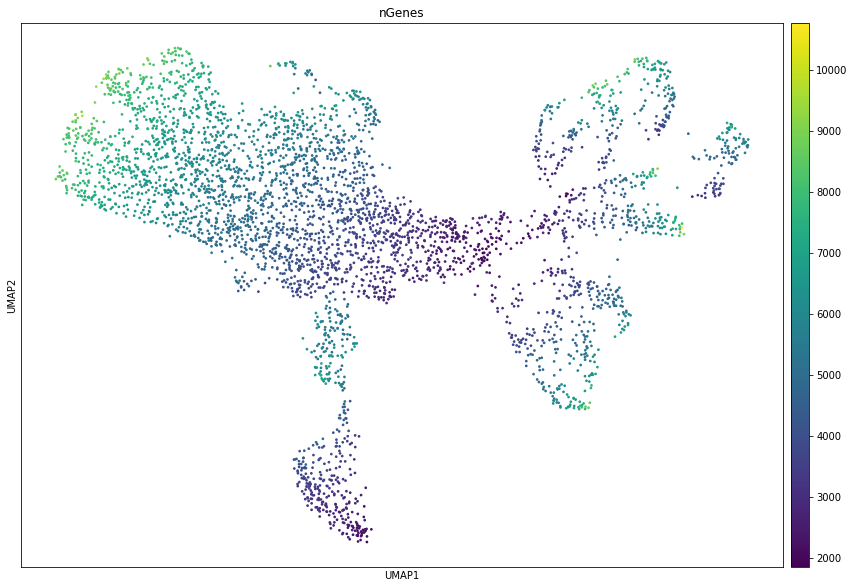

In [36]:
#cluster 0 and 8 have lower genes counts than the rest of the clusters
sc.pl.umap(inhibitory_neuron_ann,color="nGenes")

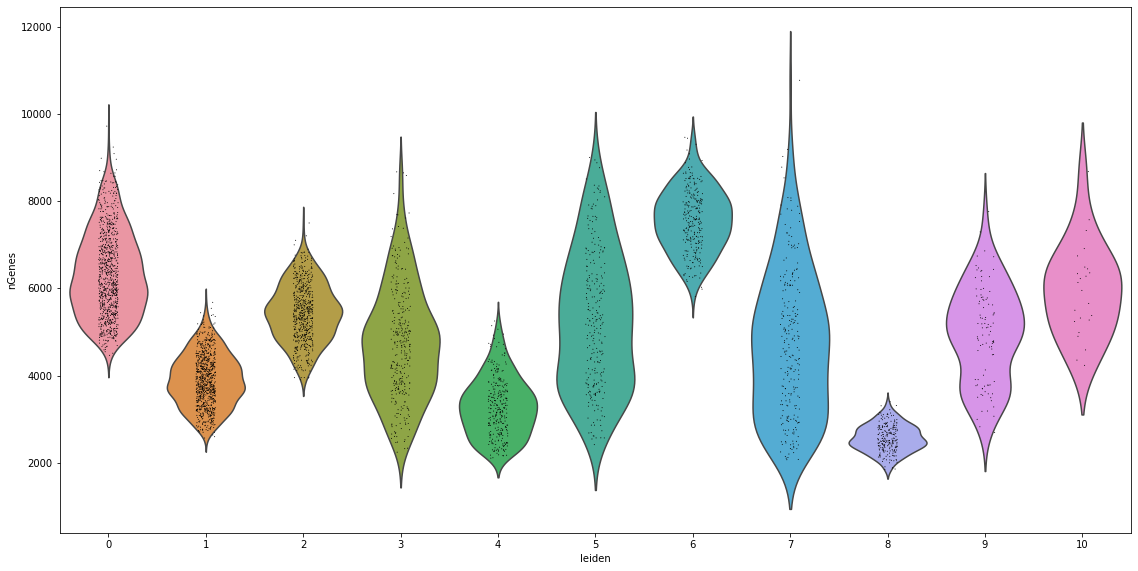

In [37]:
#cluster 0 and 8 have lower genes counts than the rest of the clusters

sc.pl.violin(inhibitory_neuron_ann,groupby="leiden",keys=["nGenes"])

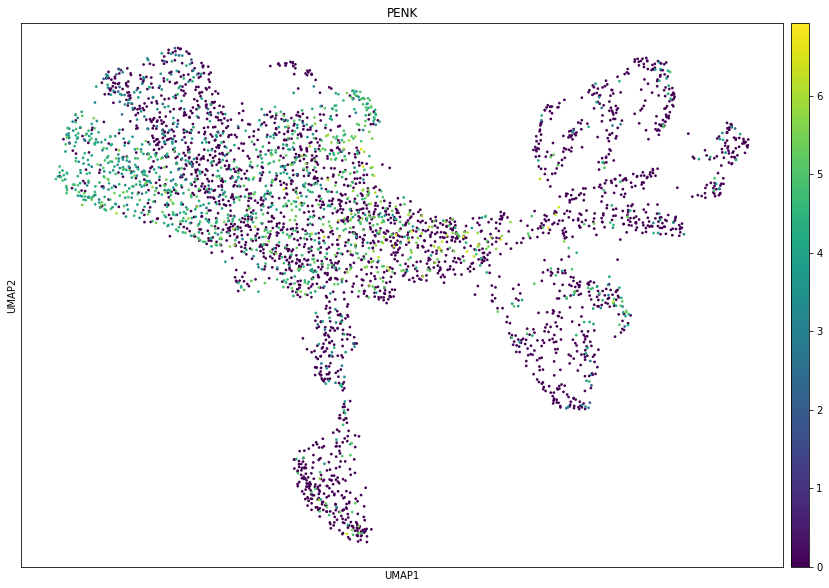

In [38]:
#D1 neuron marker visualization
sc.pl.umap(inhibitory_neuron_ann,color="PENK")

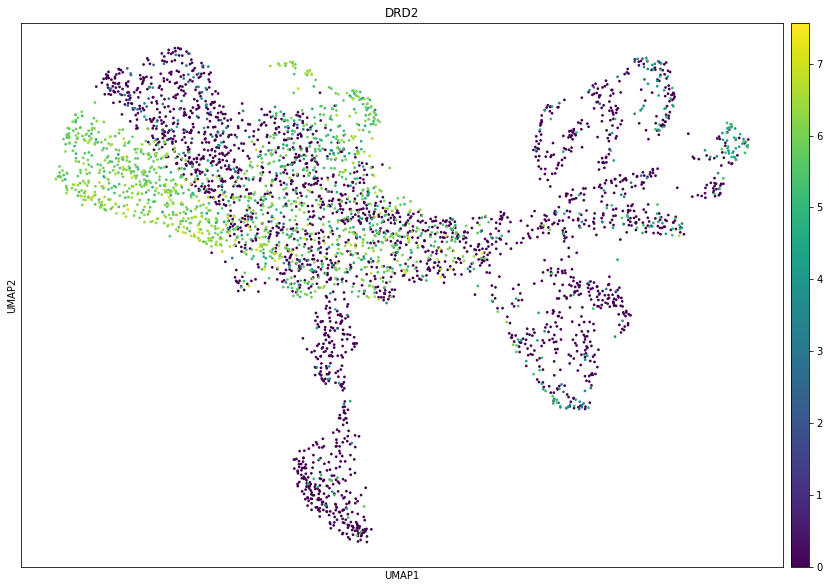

In [39]:
#D2 neuron marker visualization
sc.pl.umap(inhibitory_neuron_ann,color="DRD2")

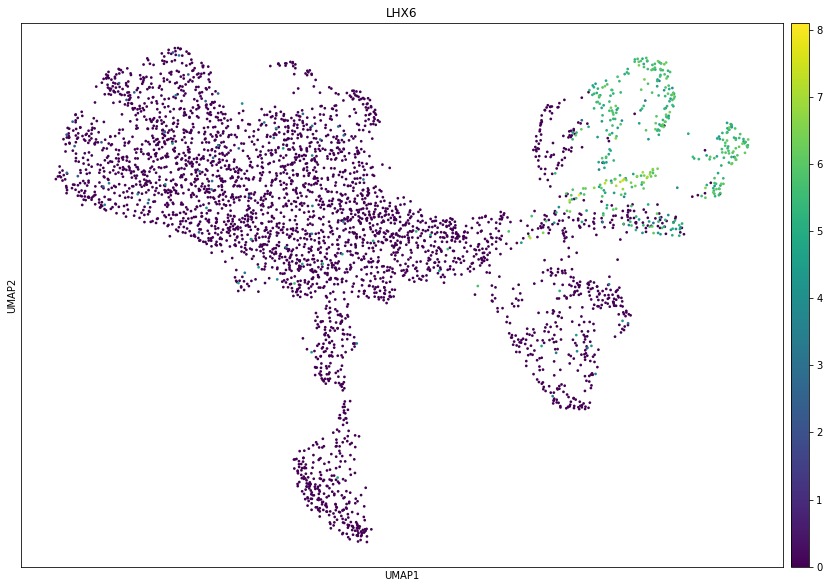

In [40]:
#inhitory neuron marker visualization

sc.pl.umap(inhibitory_neuron_ann,color="LHX6")

In [41]:
#it is likely cluster 0 and 1 contained damaged nuclei due to their low number of genes and their poor neural identity
damaged_cells_idx = np.asarray([dmg in ["1","8"] for dmg in inhibitory_neuron_ann.obs["leiden"].values])
print(np.average(inhibitory_neuron_annot["nGenes"][damaged_cells_idx]))
print(np.average(inhibitory_neuron_annot["nGenes"][np.logical_not(damaged_cells_idx)]))

3613.7996237064913
5534.113005683718


In [42]:
#we are going to choose a conservative cutoff of 3400 genes per nuclei to further qc the neurons
#to eliminate this damaged cell effect
qc_neuron_idx =inhibitory_neuron_annot["nGenes"].values>3400
qc_neuron_annot =  inhibitory_neuron_annot.loc[qc_neuron_idx ,:]
qc_neuron_df = inhibitory_neuron_df.loc[qc_neuron_idx ,:]

In [43]:
#we are now going to the same qc for the non-neurons
non_neuron_ann = AnnData(non_neuron_df)
non_neuron_ann.obs_names = non_neuron_annot["full_id"].values
non_neuron_ann.obs["nUMIs"] = non_neuron_annot["nUMIs"].values
non_neuron_ann.obs["nGenes"] = non_neuron_annot["nGenes"].values

non_neuron_ann.obs["region"] = pd.Categorical(non_neuron_annot["region"].values,np.unique(non_neuron_annot["region"].values))

non_neuron_ann.obs["doublet_score"] = non_neuron_annot["doublet_score"].values

Transforming to str index.


In [44]:
sc.pp.normalize_per_cell(non_neuron_ann, counts_per_cell_after=1e6)
sc.pp.log1p(non_neuron_ann)
sc.pp.pca(non_neuron_ann)
sc.pp.neighbors(non_neuron_ann)
sc.tl.umap(non_neuron_ann)

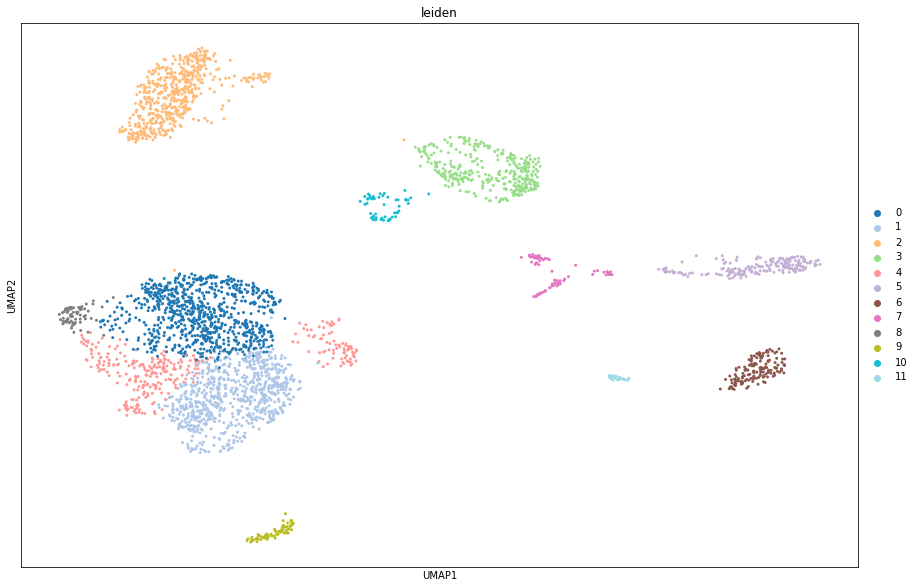

In [45]:
#let's look at a course grained clustering of the non neurons
sc.tl.leiden(non_neuron_ann,resolution=0.5)
sc.pl.umap(non_neuron_ann,color="leiden",palette="tab20")

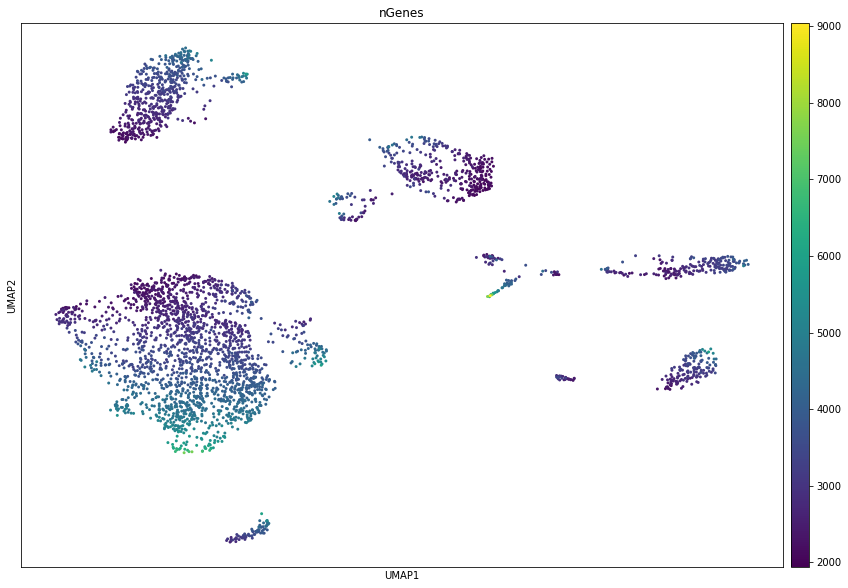

In [46]:
sc.pl.umap(non_neuron_ann,color="nGenes")

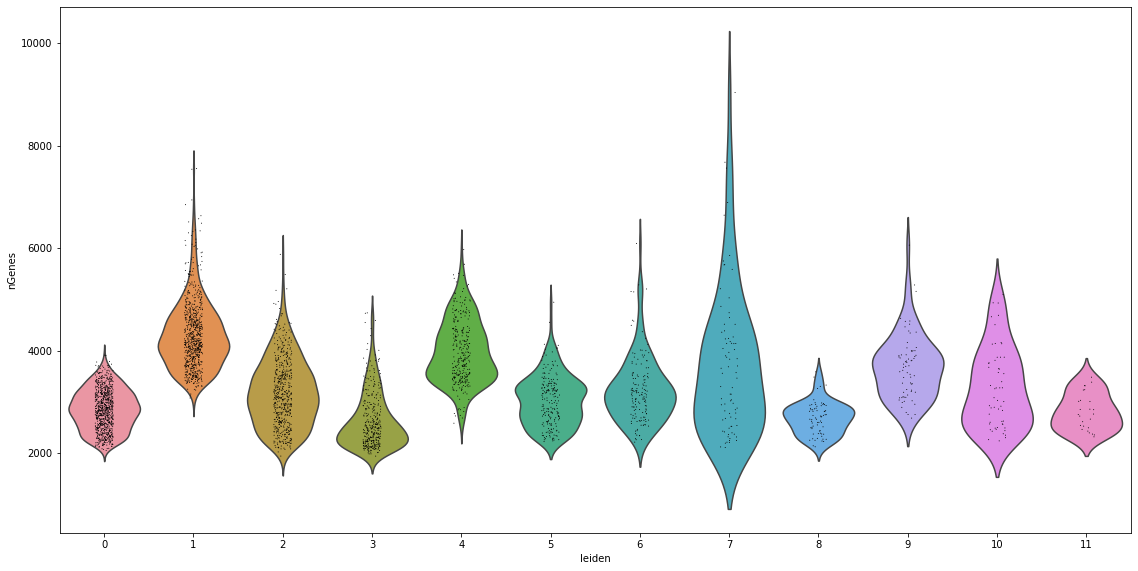

In [47]:
#as we can see the distributions look very different compared to neurons
sc.pl.violin(non_neuron_ann,groupby="leiden",keys=["nGenes"])

In [48]:
#Because we see less obvious evidence of damaged cell clusters we are going to use the damaged cell rate 
#we observed from the neurons and apply that to the non_neurons
from scipy.stats import percentileofscore
dmg_percentile = percentileofscore(inhibitory_neuron_annot["nGenes"].values,3400)
dmg_percentile


17.982239763196844

In [49]:
#we now calculate the non neuronal qc cutoff by using the damaged cell rate from the neurons
np.quantile(non_neuron_annot["nGenes"].values,dmg_percentile/100)

2547.5816477553035

In [50]:
#because non-neuronal cells in the brain generally express less genes we will use a weaker cutoff 
#for the damaged nuclei removal
qc_non_neuron_idx =non_neuron_annot["nGenes"].values>2500
qc_non_neuron_annot =  non_neuron_annot.loc[qc_non_neuron_idx ,:]
qc_non_neuron_df = non_neuron_df.loc[qc_non_neuron_idx ,:]

In [51]:
#we now combine the nuclei into a single dataframe and 
#perform a preclustering step that we will use in normalization
qc_nuclei_df = pd.concat([qc_neuron_df,qc_non_neuron_df])
qc_nuclei_annot = pd.concat([qc_neuron_annot,qc_non_neuron_annot])

In [52]:
qc_nuclei_ann = AnnData(qc_nuclei_df)
sc.pp.normalize_per_cell(qc_nuclei_ann, counts_per_cell_after=1e6)
sc.pp.log1p(qc_nuclei_ann)
sc.pp.pca(qc_nuclei_ann)
sc.pp.neighbors(qc_nuclei_ann)
sc.tl.leiden(qc_nuclei_ann)


Transforming to str index.


In [53]:
#adding the preclustering to the annoation
qc_nuclei_annot.index = qc_nuclei_annot["full_id"].values
qc_nuclei_annot["precluster"] = qc_nuclei_ann.obs["leiden"].values

In [54]:
#writing the qc gene expression and annoation files
feather.write_dataframe(qc_nuclei_df,"../data/processed/qc_nuclei.feather")
qc_nuclei_annot.to_csv("../data/processed/qc_nuclei_annotation.csv")